#Dataset management

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for advanced plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('diabetes.csv')  # Load 'diabetes.csv' into a DataFrame 'df'

Processing Dataset

In [3]:
# Features (X) and target (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data prepared!")

Data prepared!


*Show* dataset

Dataset new shape: (2000, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            2      138             62             35        0  33.6   
1            0       84             82             31      125  38.2   
2            0      145              0              0        0  44.2   
3            0      135             68             42      250  42.3   
4            1      139             62             41      480  40.7   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.127   47        1  
1                     0.233   23        0  
2                     0.630   31        1  
3                     0.365   24        1  
4                     0.536   21        0  


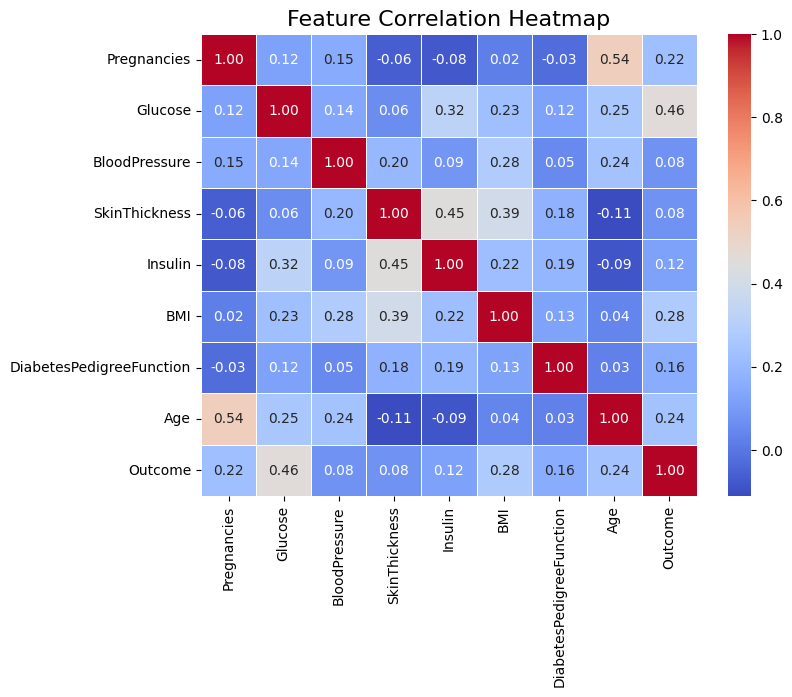

In [7]:
print("Dataset new shape:", df.shape)
print(df.head())

# correlation map
plt.figure(figsize=(8,6))

sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm',linewidths=0.5,
            annot_kws={"size": 10})

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

#Random Forest vs MLP

**Model Setup**

In [8]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Define the base models
base_models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'MLP': MLPClassifier(activation='relu',
                         solver='adam',
                         max_iter=1000,
                         random_state=42,
                         early_stopping=True) # Added for efficiency
}

# Cross-Validation set up
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grids to test
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'MLP': {
        'hidden_layer_sizes': [(32, 16), (50, 25), (100, 50)],
        'alpha': [0.001, 0.01, 0.1],
        'learning_rate_init': [0.001, 0.01]
    }
}



print("Setup complete!!")


Setup complete!!


**Hyperparameters optimization**

In [9]:
# This dictionary will store the BEST optimized models
best_models = {}

best_mlp_for_loss_plot = None

print("Starting Hyperparameter Search (GridSearchCV)...")

# Iterate over the base models and their respective parameter grids
for model_name in base_models:
    print(f"--- Optimizing: {model_name} ---")

    # Get the base model and its parameter grid
    model = base_models[model_name]
    params = param_grids[model_name]

    # Set up GridSearchCV.
    # For each combination, it runs a 5-Fold  stratified Cross-Validation
    # I use 'roc_auc' for scoring, as it's better for imbalanced datasets
    grid_search = GridSearchCV(model, params, cv=kf, scoring='roc_auc', n_jobs=-1)

    # Run the search
    grid_search.fit(X_train_scaled, y_train)

    print(f"Best score (AUC) for {model_name}: {grid_search.best_score_:.4f}")
    print(f"Best parameters found: {grid_search.best_params_}")

    # Save the best parameters combination
    best_models[model_name] = grid_search.best_estimator_

    # Save the MLP model for plot the loss curve
    if model_name == 'MLP':
        best_mlp_for_loss_plot = grid_search.best_estimator_

print("\nOptimization complete! Best models are ready.")

Starting Hyperparameter Search (GridSearchCV)...
--- Optimizing: Random Forest ---
Best score (AUC) for Random Forest: 0.9891
Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
--- Optimizing: MLP ---
Best score (AUC) for MLP: 0.9469
Best parameters found: {'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01}

Optimization complete! Best models are ready.


**Generating Predictions**

In [10]:
# Dictionary to store the results from all models
all_results = {}

# Iterates over the models
for model_name, model in best_models.items():
    print(f"--- Getting predictions for: {model_name} ---")

    y_pred = model.predict(X_test_scaled)

    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Save the results
    all_results[model_name] = {
        'y_true': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Extract results for easy access for the avaluation
rf_results = all_results['Random Forest']
mlp_results = all_results['MLP']

print("Cross-validation predictions complete!")


--- Getting predictions for: Random Forest ---
--- Getting predictions for: MLP ---
Cross-validation predictions complete!


**Loss Curve MLP**

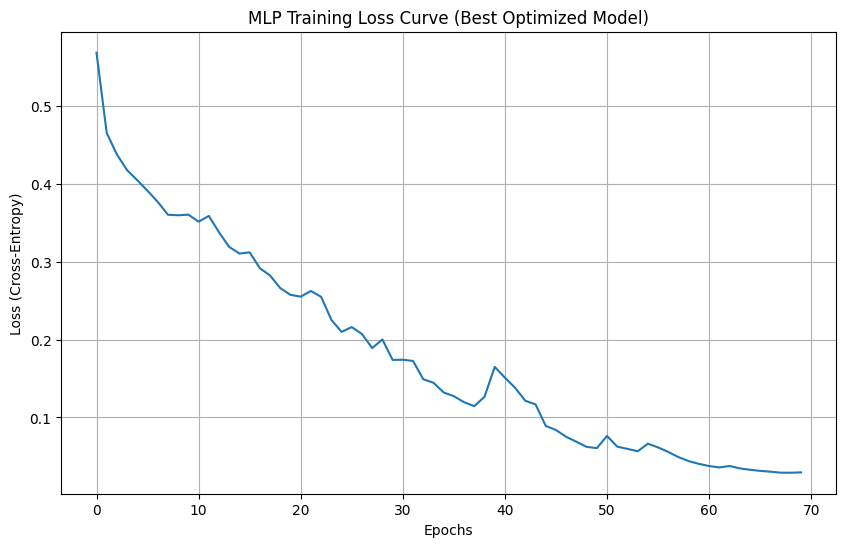

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(best_mlp_for_loss_plot.loss_curve_)
plt.title("MLP Training Loss Curve (Best Optimized Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss (Cross-Entropy)")
plt.grid(True)
plt.show()

#Evaluation

Performance Comparison:
               Accuracy  Precision    Recall  F1-score
Random Forest    0.9850   0.978102  0.978102  0.978102
MLP              0.9575   0.954545  0.919708  0.936803


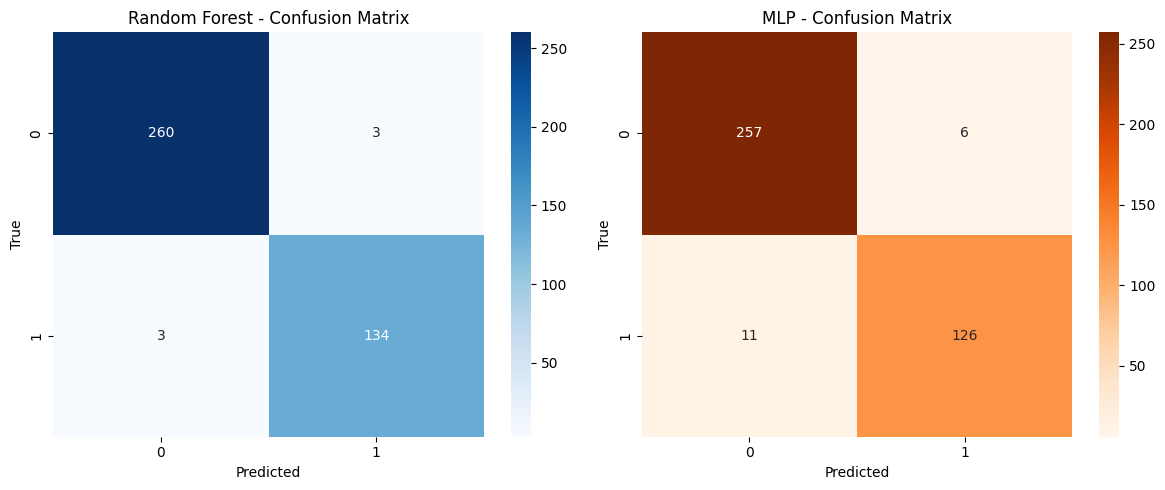

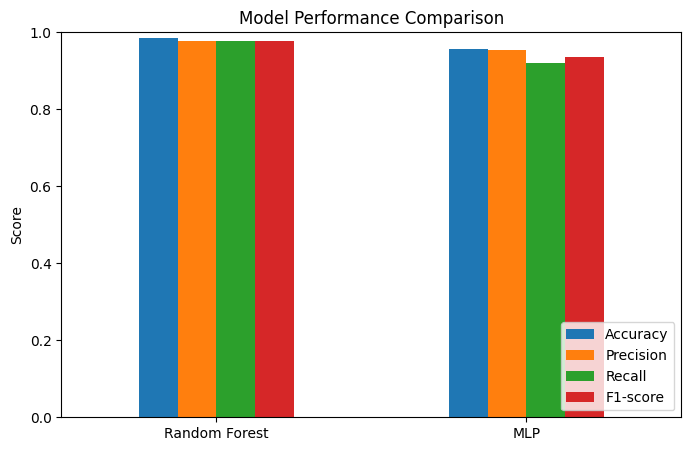

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

### Function that calculate metrics for each model ###
def evaluate_model(results_dict):
    y_true = results_dict['y_true']
    y_pred = results_dict['y_pred']
    metrics = { # Standard classification metrics.
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }
    return metrics

rf_metrics = evaluate_model(rf_results) # Evaluate the Random Forest results.
mlp_metrics = evaluate_model(mlp_results) # Evaluate the MLP results.

# Store metrics in a pandas DataFrame for easy comparison.
comparison_df = pd.DataFrame([rf_metrics, mlp_metrics], index=['Random Forest', 'MLP'])

print("Performance Comparison:")
print(comparison_df)



### Plot Confusion Matrices ###
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Create a figure with two subplots side-by-side.

# Decision Tree Confusion Matrix
sns.heatmap(confusion_matrix(rf_results['y_true'], rf_results['y_pred']),
            annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Random Forest - Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# MLP Confusion Matrix
sns.heatmap(confusion_matrix(mlp_results['y_true'], mlp_results['y_pred']),
            annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title("MLP - Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout() # Adjust plot layout.
plt.show() # Display the confusion matrices.



### Bar Plot of Metrics ###
comparison_df.plot(kind='bar', figsize=(8,5))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()


**Roc Curve**

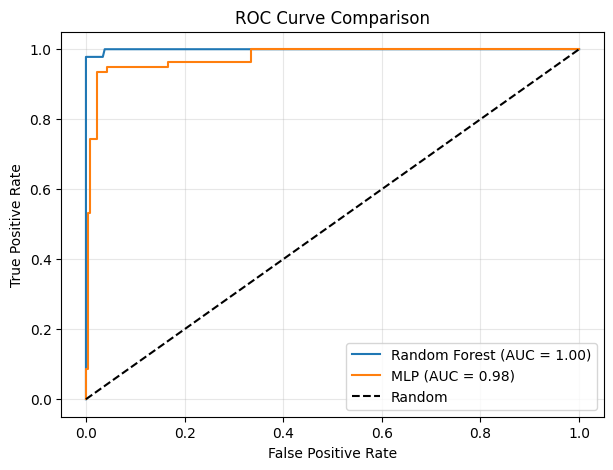

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Decision Tree
# Calculate False Positive Rate (fpr) and True Positive Rate (tpr) for RF.
fpr_dt, tpr_dt, _ = roc_curve(rf_results['y_true'], rf_results['y_proba'])
auc_dt = auc(fpr_dt, tpr_dt) # Calculate the Area Under the Curve (AUC).

# MLP
fpr_mlp, tpr_mlp, _ = roc_curve(mlp_results['y_true'], mlp_results['y_proba'])
auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC curves
plt.figure(figsize=(7,5))
plt.plot(fpr_dt, tpr_dt, label=f'Random Forest (AUC = {auc_dt:.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random') # Plot the dashed baseline (random guess).
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
